# Enquesta Condicions de vida dels usuaris dels CSS
# Tratamiento de datos
***
# 3. Análisis de datos - Multivariable

***
***
## 3.1 Carga de datos y análisis exploratorio

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_pickle('data_final/final_df.pkl')
print(df.shape)

df_mayores = df[df['Edad'] >= 65]
print(df_mayores.shape)

(6624, 143)
(1597, 143)


**Importante**: Al utilizar variables con valores NS/NC como `Categoria_Profesional` o `Valoracion_General`, hay que filtrar primero las observaciones que no sean válidas:

In [ ]:
import pandas as pd

def filter_variables(df):
    """
    Filtra el DataFrame según los siguientes criterios:
    
    1. Para las variables categóricas (tipo 'object' o 'category'),
       elimina las observaciones que contengan: "No ho sap", "No contesta" o "NS/NC".
       
    2. Para las variables numéricas que tengan en el nombre "Valoracion" o que
       estén en la lista:
       ['Millora_Autonomia', 'Millora_Anim', 'Sentimient_Companyia', 
        'Sentimient_Tranquilitat', 'Sentimient_Seguretat', 'Satisfaccio_Vital', 
        'Benefici_Familia'],
       elimina las observaciones cuyos valores sean exactamente 98 o 99.
       
    Args:
        df (DataFrame): DataFrame de entrada con las variables preseleccionadas.
        
    Returns:
        DataFrame: Una copia del DataFrame filtrado según los criterios anteriores.
    """
    # Imprimir shape original
    print("Shape original del DataFrame:", df.shape)
    
    # Crear una copia para no modificar el DataFrame original
    df_filtered = df.copy()
    
    # 1. Filtrar variables categóricas
    invalid_cat = {"No ho sap", "No contesta", "NS/NC"}
    # Seleccionar columnas categóricas utilizando select_dtypes
    categorical_columns = df_filtered.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
        # Eliminar las filas que tengan valores no válidos en la columna
        df_filtered = df_filtered[~df_filtered[col].isin(invalid_cat)]
    
    # 2. Filtrar variables numéricas específicas
    additional_list = [
        'Millora_Autonomia', 'Millora_Anim', 'Sentimient_Companyia', 
        'Sentimient_Tranquilitat', 'Sentimient_Seguretat', 'Satisfaccio_Vital', 
        'Benefici_Familia'
    ]
    invalid_num = {98, 99}
    # Seleccionar columnas numéricas (int y float)
    numerical_columns = df_filtered.select_dtypes(include=['int64', 'float64']).columns
    for col in numerical_columns:
        # Si el nombre de la columna contiene "Valoracion" o está en additional_list, filtrar
        if ("Valoracion" in col) or (col in additional_list):
            df_filtered = df_filtered[~df_filtered[col].isin(invalid_num)]
    
    # Imprimir shape después del filtrado
    print("Shape del DataFrame después del filtrado:", df_filtered.shape)
    
    return df_filtered

# Ejemplo de uso:
#variables_preseleccionadas = ['Categoria_Profesional', 'Valoracion_General']
#df_filtered = filter_variables(df[variables_preseleccionadas])

***
***
## 3.2 Factor Analysis (FA)

El Análisis de Factores (FA) es una técnica estadística que busca identificar factores latentes que explican las relaciones entre un conjunto de variables observadas. Estos factores representan dimensiones subyacentes que agrupan variables correlacionadas, simplificando la estructura de los datos.

#### Requisitos en los datos:

- **Variables continuas** o variables ordinales: FA asume que las variables tienen relaciones lineales.
- Ausencia de multicolinealidad extrema: Las variables no deben ser redundantes.
- **Correlaciones significativas**: Es ideal que las variables estén correlacionadas, pero no de forma excesiva.
- Tamaño muestral suficiente: Se recomienda tener al menos 5-10 observaciones por variable.

#### Buenas prácticas:

- Seleccionar el número óptimo de factores:
    - Utilizar el criterio de Kaiser (retener factores con valores propios > 1).
    - Graficar el "codo" de los valores propios.
- Rotar los factores:
    - Usar rotaciones como Varimax para facilitar la interpretación de los resultados.
- Eliminar variables no relevantes:
    - Variables con cargas bajas o distribuciones anómalas pueden ser descartadas.
- Escalar los datos:
    - Asegurarse de que las variables estén estandarizadas para evitar sesgos.
  
#### Conclusión previa:

FA se basa en correlaciones o covarianzas. Busca factores latentes que explican la variabilidad de un conjunto de variables. Para hacerlo, utiliza la matriz de correlación o matriz de covarianza. El problema es que las variables numéricas escaladas suelen distribuirse de manera normal, mientras que las variables categóricas (One-Hot Encoding) son binarias. Esto puede distorsionar la matriz de correlación y afectar la validez de los factores extraídos.

**No nos sirve porque tenemos muchas variables categóricas!!**

### Funciones

In [12]:
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def preprocess_for_fa(df, variables):
    """
    Preprocesa las variables seleccionadas para el análisis de factores,
    incluyendo la codificación de variables categóricas.
    
    Args:
        df (DataFrame): Conjunto de datos original.
        variables (list): Lista de variables a incluir en el análisis.
        
    Returns:
        ndarray: Datos preprocesados y listos para el análisis.
        list: Nombres de las características procesadas.
    """
    # Seleccionar las columnas relevantes
    df_filtered = df[variables].dropna()

    # Separar variables categóricas y numéricas
    categorical_columns = df_filtered.select_dtypes(include=['object', 'category']).columns
    numerical_columns = df_filtered.select_dtypes(include=['int64', 'float64']).columns

    # Codificar variables categóricas
    encoder = OneHotEncoder() #drop='first')
    if len(categorical_columns) > 0:
        encoded_categoricals = encoder.fit_transform(df_filtered[categorical_columns]).toarray()
        encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
    else:
        encoded_categoricals = np.empty((df_filtered.shape[0], 0))
        encoded_feature_names = []

    # Escalar variables numéricas
    scaler = StandardScaler()
    scaled_numericals = scaler.fit_transform(df_filtered[numerical_columns])

    # Combinar los datos procesados
    combined_data = np.hstack([scaled_numericals, encoded_categoricals])
    combined_feature_names = list(numerical_columns) + list(encoded_feature_names)

    return combined_data, combined_feature_names


def check_factor_analysis_suitability(data):
    kmo_all, kmo_model = calculate_kmo(data)
    chi2, p_val = calculate_bartlett_sphericity(data)

    print(f"KMO: {kmo_model:.3f} (Debe ser > 0.6)")
    print(f"Bartlett Test p-value: {p_val:.3f} (Debe ser < 0.05 para que FA sea adecuado)")

    return kmo_model > 0.6 and p_val < 0.05


# Aplicar FA
def factor_analysis_with_variances(data, feature_names, n_factors=3, rotation='varimax'):
    """
    Realiza FA con datos ya procesados.
    
    Args:
        data (ndarray): Datos preprocesados para FA.
        feature_names (list): Nombres de las características.
        n_factors (int): Número de factores.

    Returns:
        DataFrame: Cargas factoriales.
        DataFrame: Varianza explicada.
    """
    # Aplicar FA
    fa = FactorAnalysis(n_components=n_factors, random_state=42)
    fa.fit(data)
    
    # Cargas factoriales
    loadings = pd.DataFrame(
        fa.components_.T,
        index=feature_names,
        columns=[f'Factor {i+1}' for i in range(n_factors)]
    )
    
    # Varianza explicada (aproximación)
    fa_result = fa.fit_transform(data)
    factor_variances = np.var(fa_result, axis=0)
    total_variance = np.sum(factor_variances)
    explained_variance = pd.DataFrame({
        'Factor': [f'Factor {i+1}' for i in range(n_factors)],
        'Varianza Explicada': factor_variances / total_variance
    })

    return loadings, explained_variance


def scree_plot(data):
    """
    Sirve para visualizar el Scree Plot y determinar el número de componentes a retener.
    """
    pca = PCA()
    pca.fit(data)
    plt.plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='o')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Varianza Explicada')
    plt.title('Scree Plot')
    plt.show()

### Ejemplo de uso

In [13]:
# Seleccionar variables numéricas relevantes para el análisis de factores
variables_to_analyze = [
    'Edad', 'Renda_Total_Llar', 'N_Hijos_Llar', 'Horas_Domesticas', 
    'Horas_Cuidados', 'Valoracion_General'
]

# Filtrar las que tengan valores no válidos
df_filtered = filter_variables(df[variables_to_analyze])

# Preprocesar las variables seleccionadas
processed_data, feature_names = preprocess_for_fa(df_filtered, variables_to_analyze)

Shape original del DataFrame: (6624, 6)
Shape del DataFrame después del filtrado: (6508, 6)


In [14]:
check_factor_analysis_suitability(processed_data)

KMO: 0.707 (Debe ser > 0.6)
Bartlett Test p-value: 0.000 (Debe ser < 0.05 para que FA sea adecuado)


True

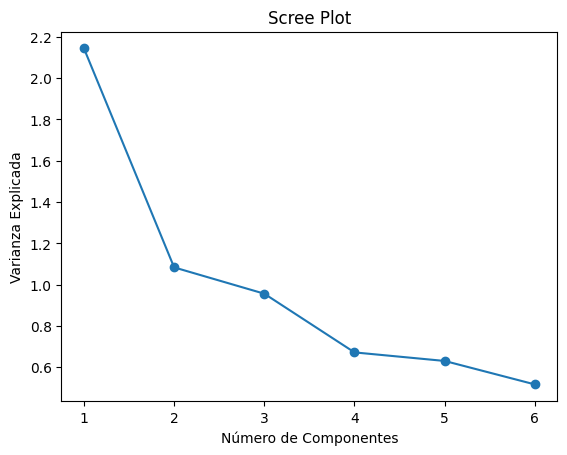

In [15]:
scree_plot(processed_data)

In [ ]:
# Recalcular FA con varianza explicada correctamente
loadings_corrected, explained_variance_corrected = factor_analysis_with_variances(processed_data, feature_names, n_factors=2)
print(loadings_corrected)
print(explained_variance_corrected)

### Interpretación de resultados


1. Cargas factoriales:
Las cargas factoriales indican la influencia de cada variable en los factores.
- Cargas altas (positivas o negativas): La variable está fuertemente relacionada con el factor correspondiente.
- Cargas bajas (cerca de 0): La variable tiene poca relación con ese factor.
    
Ejemplo práctico: si la variable Edad tiene una alta carga en el Factor 1, este factor puede estar relacionado con aspectos demográficos.

2. Varianza explicada:

- Indica qué porcentaje de la variabilidad total en los datos está explicado por cada factor. Factores que explican poca varianza pueden ser menos relevantes para la interpretación.
        
Ejemplo: si el Factor 1 explica el 38% de la varianza, es el más representativo de los patrones en los datos.

#### Importancia del número de factores:

- Pocos factores:
    - Simplifican el modelo y facilitan la interpretación, pero pueden perder detalles.
    - Útil si la meta es capturar patrones generales.
- Más factores:
    - Explican más varianza, pero pueden generar ruido y dificultar la interpretación.
    - Necesario si hay múltiples patrones importantes en los datos.

#### Elección óptima:

Depende de un compromiso entre la varianza explicada y la simplicidad del modelo. Se puede usar:
- El criterio de Kaiser: Retener factores con valores propios (λλ) mayores que 1.
- Análisis gráfico: Observar un gráfico de codo para determinar el punto donde la varianza explicada se estabiliza.

#### Uso práctico de FA para seleccionar variables:
- Identificar variables relevantes:
    - Examina las cargas factoriales altas en cada factor.
    - Variables con cargas altas en múltiples factores son más influyentes.
- Entender relaciones entre variables:
    - Si dos variables tienen cargas similares en un mismo factor, están relacionadas.
    - Esto puede ser útil para agrupar variables o simplificar modelos.
- Reducción de dimensionalidad:
    - Usa solo los factores más relevantes en lugar de todas las variables originales.

***
***
## 2.3 PCA

El Análisis de Componentes Principales (PCA) es una técnica de reducción de dimensionalidad que transforma un conjunto de variables originales en un número reducido de componentes principales, que son combinaciones lineales de las variables originales. Las primeras componentes explican la mayor parte de la variabilidad en los datos.

#### Requisitos en los datos:

- Variables continuas o transformadas: Las variables deben estar numéricas y estandarizadas.
- Ausencia de outliers extremos: Los valores atípicos pueden influir en los resultados.
- Correlaciones significativas: PCA funciona mejor cuando las variables están correlacionadas.

#### Buenas prácticas:
- Estandarizar los datos:
    - Variables en diferentes escalas pueden sesgar las componentes principales.
- Elegir el número adecuado de componentes:
    - Usar el criterio de varianza explicada acumulada (retener componentes hasta que expliquen el 80-90%).
- Visualizar las componentes:
    - Usar gráficos como biplots para interpretar las relaciones entre variables y componentes.
- Evaluar la varianza explicada:
    - Priorizar componentes con valores propios > 1.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Selección de variables relevantes
variables_categoricas = ['Sexo', 'Nivel_Estudios', 'Tipo_Hogar',
                         'Visita_CSS_Econom', 'Visita_CSS_Familia', 'Visita_CSS_Depend']
variables_numericas = ['Edad', 'Renda_Total_Llar', 'N_Hijos_Llar']

# Asegurarse de que se eliminan filas con valores nulos en todas las variables seleccionadas
df_mca = df[variables_categoricas + variables_numericas].dropna()

# Transformar variables categóricas con OneHotEncoding
encoder = OneHotEncoder(drop='first')  # Retirado el parámetro 'sparse' para compatibilidad
encoded_categoricas = encoder.fit_transform(df_mca[variables_categoricas]).toarray()  # Convertir a array denso

# Escalar variables numéricas
scaler = StandardScaler()
scaled_numericas = scaler.fit_transform(df_mca[variables_numericas])

# Confirmar las dimensiones de ambas matrices
encoded_categoricas.shape, scaled_numericas.shape

# Combinar datos categóricos codificados y numéricos escalados
data_combined = np.hstack([encoded_categoricas, scaled_numericas])

# Verificar la nueva forma combinada
data_combined.shape

(6216, 14)

Las matrices categóricas y numéricas tienen dimensiones compatibles. La combinación resultante tiene:

- 6216 observaciones.
- 15 características combinadas (categóricas codificadas + numéricas escaladas).

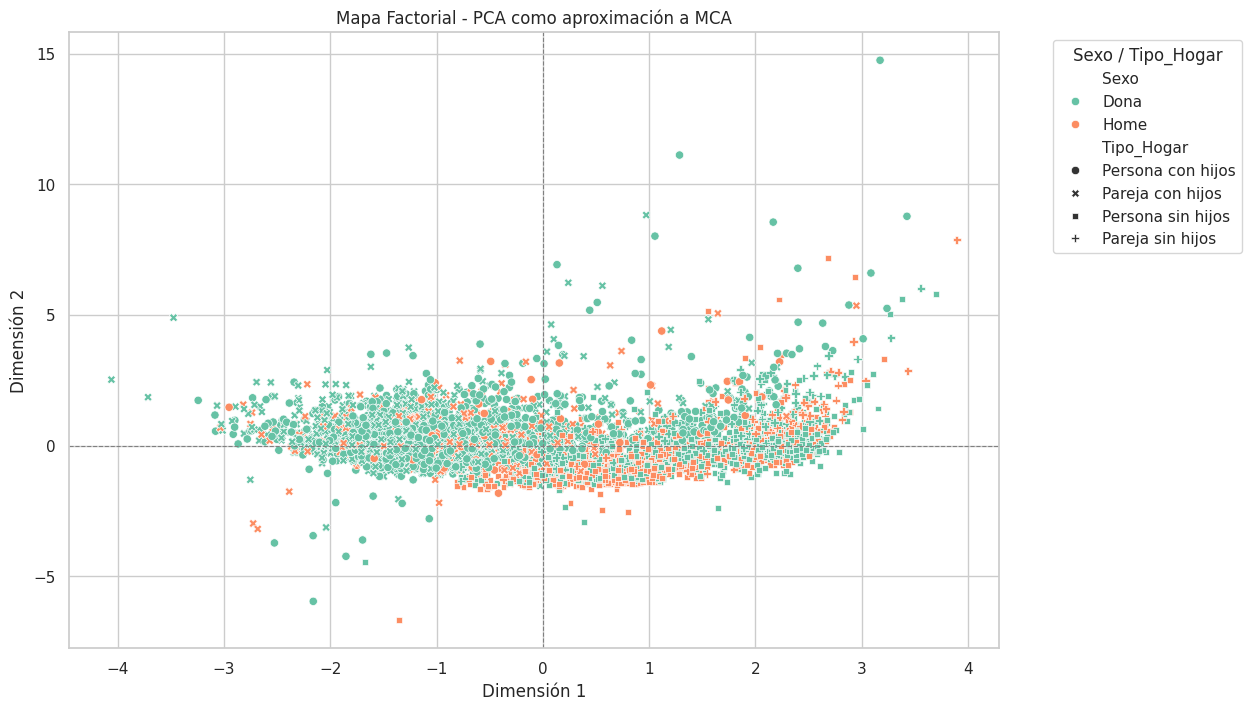

array([0.37547183, 0.21695715])

In [ ]:
# Aplicar PCA como aproximación al MCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(data_combined)

# Crear un DataFrame para las coordenadas del PCA
pca_coords_df = pd.DataFrame(pca_result, columns=['Dim1', 'Dim2'])
pca_coords_df['Sexo'] = df_mca['Sexo'].values
pca_coords_df['Nivel_Estudios'] = df_mca['Nivel_Estudios'].values
pca_coords_df['Tipo_Hogar'] = df_mca['Tipo_Hogar'].values


# Visualización del mapa factorial
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_coords_df, x='Dim1', y='Dim2', hue='Sexo', style='Tipo_Hogar', palette='Set2')
plt.title('Mapa Factorial - PCA como aproximación a MCA')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.axvline(0, color='gray', linewidth=0.8, linestyle='--')
plt.legend(title='Sexo / Tipo_Hogar', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Mostrar la varianza explicada por las dos dimensiones
pca.explained_variance_ratio_

Resultados del análisis con PCA como aproximación a MCA

- Varianza explicada:
    - Dimensión 1: 35.55% de la variabilidad.
    - Dimensión 2: 20.97% de la variabilidad.
    - En conjunto, las dos dimensiones explican aproximadamente el 56.52% de la variabilidad.

- Mapa factorial:
    - Se observa una clara diferenciación en el espacio reducido por categorías como Sexo y Estado Civil.
    - Las posiciones de los puntos reflejan similitudes y diferencias según los motivos de asistencia (Visita_CSS_Econom, Visita_CSS_Familia, y Visita_CSS_Depend), así como las características demográficas y económicas (como Nivel_Estudios y Edad).

- Interpretación inicial:
    - La primera dimensión podría estar relacionada con factores económicos y educativos.
    - La segunda dimensión parece influenciada por los motivos de asistencia y las características sociodemográficas, como el estado civil.

#### Interpretación de los resultados

- Componentes principales:
    - Las primeras componentes explican la mayor parte de la variabilidad.

- Cargas de las variables:
    - Indican cuánto contribuye cada variable a una componente.

- Proyección de los datos:
    - Los datos proyectados en el espacio PCA pueden usarse para clusterización o visualización.

### Explicación: "PCA como aproximación a MCA"

El Análisis de Correspondencia Múltiple (MCA) es una técnica específica diseñada para analizar relaciones entre variables categóricas, extendiendo el Análisis de Correspondencia Simple (CA) para múltiples dimensiones. El PCA (Análisis de Componentes Principales), por otro lado, se usa comúnmente para datos numéricos, pero puede servir como una aproximación al MCA cuando las variables categóricas se codifican como dummies (matriz de variables binarias).

En este caso, estamos usando PCA porque:
- Es compatible con datos categóricos codificados y numéricos combinados.
- Facilita la interpretación al reducir la dimensionalidad y revelar relaciones latentes entre las categorías.

***
***
## 2.4 Multiple Correspondence Analysis (MCA)

El Análisis de Correspondencia Múltiple (MCA) es una técnica de reducción de dimensionalidad para variables categóricas. Busca identificar relaciones entre categorías de diferentes variables al proyectarlas en un espacio de menor dimensión.

#### Requisitos en los datos:
- **Variables categóricas**: MCA requiere que las variables sean discretas o transformadas a categorías.
- Datos **sin valores nulos**: Es necesario imputar o eliminar filas con datos faltantes.
- Suficiente variabilidad: Las categorías no deben estar demasiado desequilibradas.

#### Buenas prácticas:
- Codificación correcta de las variables:
    - Variables categóricas deben ser transformadas adecuadamente (e.g., OneHotEncoder).
- Elegir el número de dimensiones:
    - Analizar la inercia acumulada (similar a la varianza explicada en PCA) para retener dimensiones relevantes.
- Explorar correlaciones iniciales:
    - Asegurarse de que las categorías tengan asociaciones significativas.

#### Nota sobre la inclusión de la variable objetivo

En este caso queremos detectar qué variables permiten identificar la variable "objetivo", entonces no se debería incluir en el MCA. Ya que:
- El MCA encuentra patrones en todas las variables: Si se incluye la variable objetivo, estamoes forzando el algoritmo a considerarla en la construcción de los ejes principales, lo que puede afectar la detección de relaciones espontáneas.
- Evitamos sesgo en la reducción dimensional: El MCA proyectará la variable objetivo en los ejes de inercia junto con las otras variables. Si está incluida, su variabilidad influirá en la formación de los componentes, lo que puede ocultar patrones reales.

Podría ser interesante incluirla para ver que pasa cuando:
- Se quiere analizar su posición en el espacio factorial: Si queremos ver cómo se proyecta la variable objetivo junto con las demás, podemos incluirla, pero se debe interpretar con cuidado si su influencia es fuerte.
- Si la variable objetivo tiene pocas categorías (Ej. Sí/No, Bueno/Malo, etc.): En estos casos, puede ser más interesante ver cómo se agrupan los puntos cuando la variable está incluida, especialmente si hay una relación clara con otras variables.

Un ejercicio interesante es realizar ambos procesos, de esta manera podemos comparar los resultados:
- Si al excluir la variable objetivo sigues viendo agrupaciones claras en función de ella, significa que otras variables realmente la están determinando.
- Si la inclusión de la variable objetivo cambia drásticamente la estructura, significa que estaba influyendo demasiado en el análisis.

### Funciones

In [ ]:
from prince import MCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_scree_mca(mca):
    """
    Dibuja el gráfico de sedimentación (Scree Plot) para MCA.
    
    Args:
        mca (prince.MCA): Modelo de MCA entrenado.
    """
    eig_vals = mca.eigenvalues_
    var_exp = eig_vals / eig_vals.sum()  # Varianza explicada

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(eig_vals) + 1), var_exp.cumsum(), marker='o', linestyle='--')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Varianza Acumulada')
    plt.title('Scree Plot - MCA')
    plt.grid()
    plt.show()


def apply_mca(df, variables, target_var=None, n_components=2):
    """
    Aplica el Análisis de Correspondencias Múltiples (MCA) a un conjunto de datos.
    
    Args:
        df (DataFrame): Conjunto de datos original.
        variables (list): Lista de variables a incluir en el análisis.
        n_components (int): Número de componentes principales a extraer.

    Returns:
        mca (prince.MCA): Modelo de MCA entrenado.
        df_mca_coords (DataFrame): Coordenadas de observaciones en el espacio MCA con variables originales.
    """
    # # Filtrar las columnas categóricas y eliminar valores faltantes
    df_train = df[variables]
    if target_var:
        df_target = df[target_var]

    # Aplicar MCA
    mca = MCA(n_components=n_components, engine='sklearn', random_state=42)
    mca.fit(df_train)

    # Obtener coordenadas de las filas
    df_mca_coords = mca.row_coordinates(df_train)
    df_mca_coords.columns = [f'Dim{i+1}' for i in range(n_components)]  # Renombrar columnas

    # Agregar las variables originales al DataFrame de coordenadas
    df_mca_coords = pd.concat([df_mca_coords, df_train.reset_index(drop=True)], axis=1)
    df_mca_coords = pd.concat([df_mca_coords, df_target.reset_index(drop=True)], axis=1)

    # Imprimir varianza explicada
    print("Varianza Explicada por Dimensión:")
    print(mca.eigenvalues_summary)

    return mca, df_mca_coords


def plot_mca(
    df_coords,
    x_dim="Dim1",
    y_dim="Dim2",
    hue_var=None,
    style_var=None,
    title="Mapa Factorial - MCA"
):
    """
    Genera un gráfico bidimensional del espacio MCA con opciones para cambiar dimensiones, colores y estilos.
    
    Args:
        df_coords (DataFrame): Coordenadas de observaciones en el espacio MCA con variables originales.
        x_dim (str): Nombre de la dimensión en el eje X (por defecto, 'Dim1').
        y_dim (str): Nombre de la dimensión en el eje Y (por defecto, 'Dim2').
        hue_var (str, opcional): Variable categórica para colorear los puntos.
        style_var (str, opcional): Variable categórica para diferenciar los puntos por estilo/forma.
        title (str): Título del gráfico.
    """
    plt.figure(figsize=(12, 8))

    # Validar que las columnas x_dim y y_dim existen
    if x_dim not in df_coords.columns or y_dim not in df_coords.columns:
        raise ValueError(f"El DataFrame no contiene las columnas {x_dim} y/o {y_dim} necesarias para graficar.")

    sns.scatterplot(
        data=df_coords,
        x=x_dim,
        y=y_dim,
        hue=hue_var,
        style=style_var,
        alpha=0.7,
        palette="Set2"
    )

    # Ajustar leyendas y etiquetas
    if hue_var or style_var:
        legend_title = f"{hue_var}" + (f" / {style_var}" if style_var else "")
        plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    plt.axvline(0, color="gray", linestyle="--", linewidth=0.8)
    plt.title(title)
    plt.xlabel(x_dim)
    plt.ylabel(y_dim)
    plt.show()


# Función para graficar en el espacio MCA
def plot_mca_old(df_coords, x_var, y_var=None, title='Mapa Factorial - MCA'):
    plt.figure(figsize=(12, 8))
    if y_var:
        sns.scatterplot(data=df_coords, x='Dim1', y='Dim2', hue=x_var, style=y_var, alpha=0.7, palette='Set2')
        plt.legend(title=f'{x_var} / {y_var}', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        sns.scatterplot(data=df_coords, x='Dim1', y='Dim2', hue=x_var, alpha=0.7, palette='Set2')
        plt.legend(title=x_var, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.xlabel('Dimensión 1')
    plt.ylabel('Dimensión 2')
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.show()



def plot_multiple_mca(df_coords, configs, figsize=(16, 12)):
    """
    Genera múltiples gráficos MCA en una misma figura.
    
    Args:
        df_coords (DataFrame): Coordenadas del MCA con variables originales.
        configs (list of dict): Lista de configuraciones para los gráficos. Cada configuración debe ser un dict con:
            - x_dim (str): Dimensión para el eje X.
            - y_dim (str): Dimensión para el eje Y.
            - hue_var (str): Variable para colorear los puntos.
            - style_var (str, opcional): Variable para diferenciar por forma.
            - title (str, opcional): Título del subgráfico.
        figsize (tuple): Tamaño de la figura total.
    """
    n_plots = len(configs)
    n_cols = 2
    n_rows = (n_plots + 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()  # Aplanar para facilitar el acceso a los ejes

    for i, config in enumerate(configs):
        ax = axes[i]
        sns.scatterplot(
            data=df_coords,
            x=config.get("x_dim", "Dim1"),
            y=config.get("y_dim", "Dim2"),
            hue=config.get("hue_var"),
            style=config.get("style_var"),
            alpha=0.7,
            palette="Set2",
            ax=ax
        )
        ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
        ax.axvline(0, color="gray", linestyle="--", linewidth=0.8)
        ax.set_title(config.get("title", "Mapa Factorial"))
        ax.set_xlabel(config.get("x_dim", "Dim1"))
        ax.set_ylabel(config.get("y_dim", "Dim2"))
        if config.get("hue_var") or config.get("style_var"):
            ax.legend(title=config.get("hue_var") + (f" / {config.get('style_var')}" if config.get("style_var") else ""))
    
    # Eliminar ejes vacíos si hay menos gráficos que subgráficos
    for j in range(len(configs), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

### Ejemplo de uso

In [49]:
# Variables categóricas a incluir en el análisis
variables_categoricas = [
    'Nivel_Estudios', 'Tipo_Hogar', 'Visita_CSS_Econom',
    'Visita_CSS_Familia', 'Visita_CSS_Depend', 'Relacio_Activitat_Recod',
    'Pais_Nacimiento', 'Propietat_Habitatge', 'Situacion_Laboral', 
    'Estado_Salud_Recod'
]
target = ["Sexo"]

all_vars = variables_categoricas + target

df_filtered = filter_variables(df[all_vars])

Shape original del DataFrame: (6624, 11)
Shape del DataFrame después del filtrado: (6610, 11)


In [53]:
# Aplicar MCA
mca_model, df_mca_coords = apply_mca(df_filtered, variables_categoricas, target, n_components=2)

Varianza Explicada por Dimensión:
          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.389         9.05%                      9.05%
1              0.219         5.10%                     14.16%


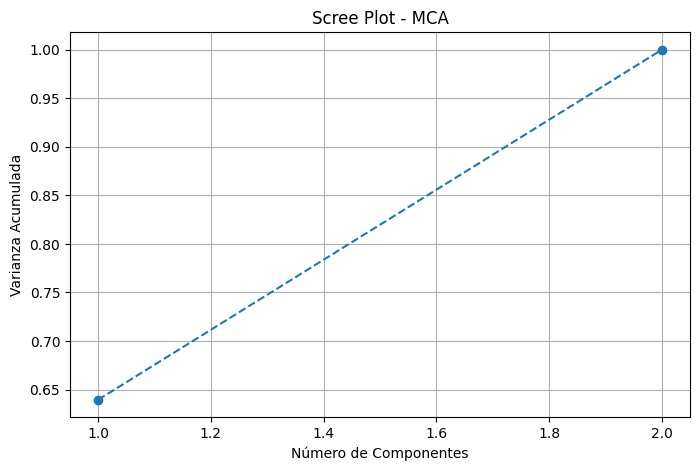

In [26]:
# Graficar Scree Plot
plot_scree_mca(mca_model)

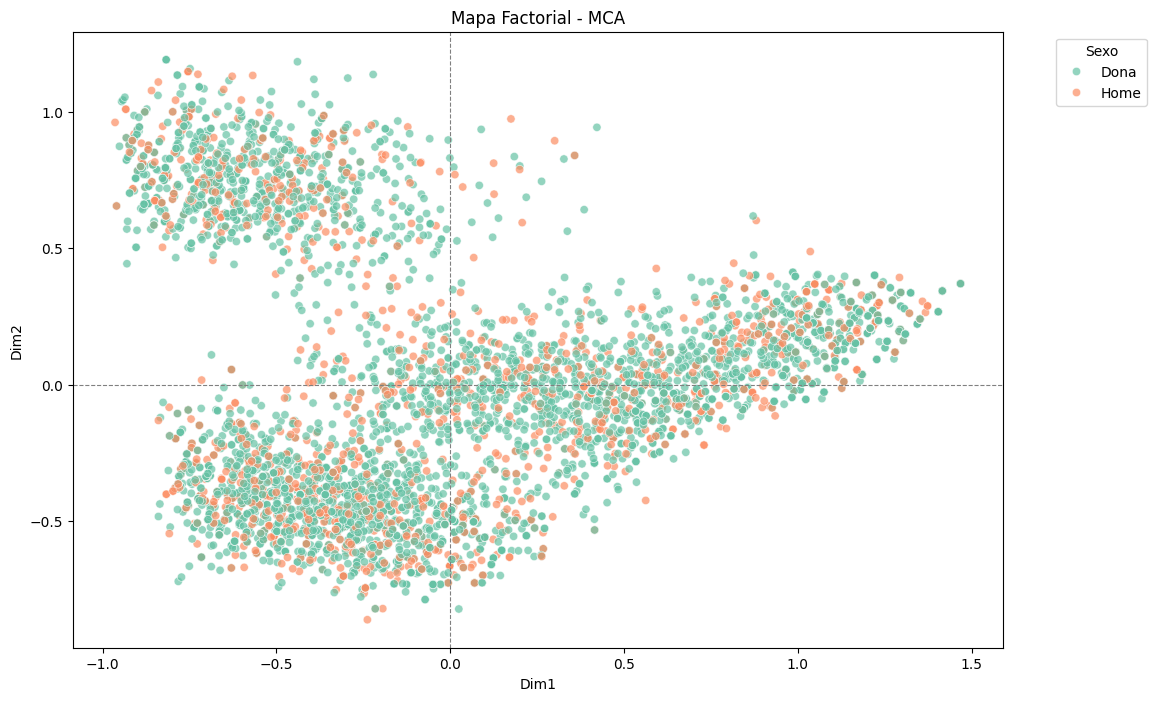

In [54]:
# Graficar resultados
plot_mca(df_mca_coords, hue_var='Sexo')

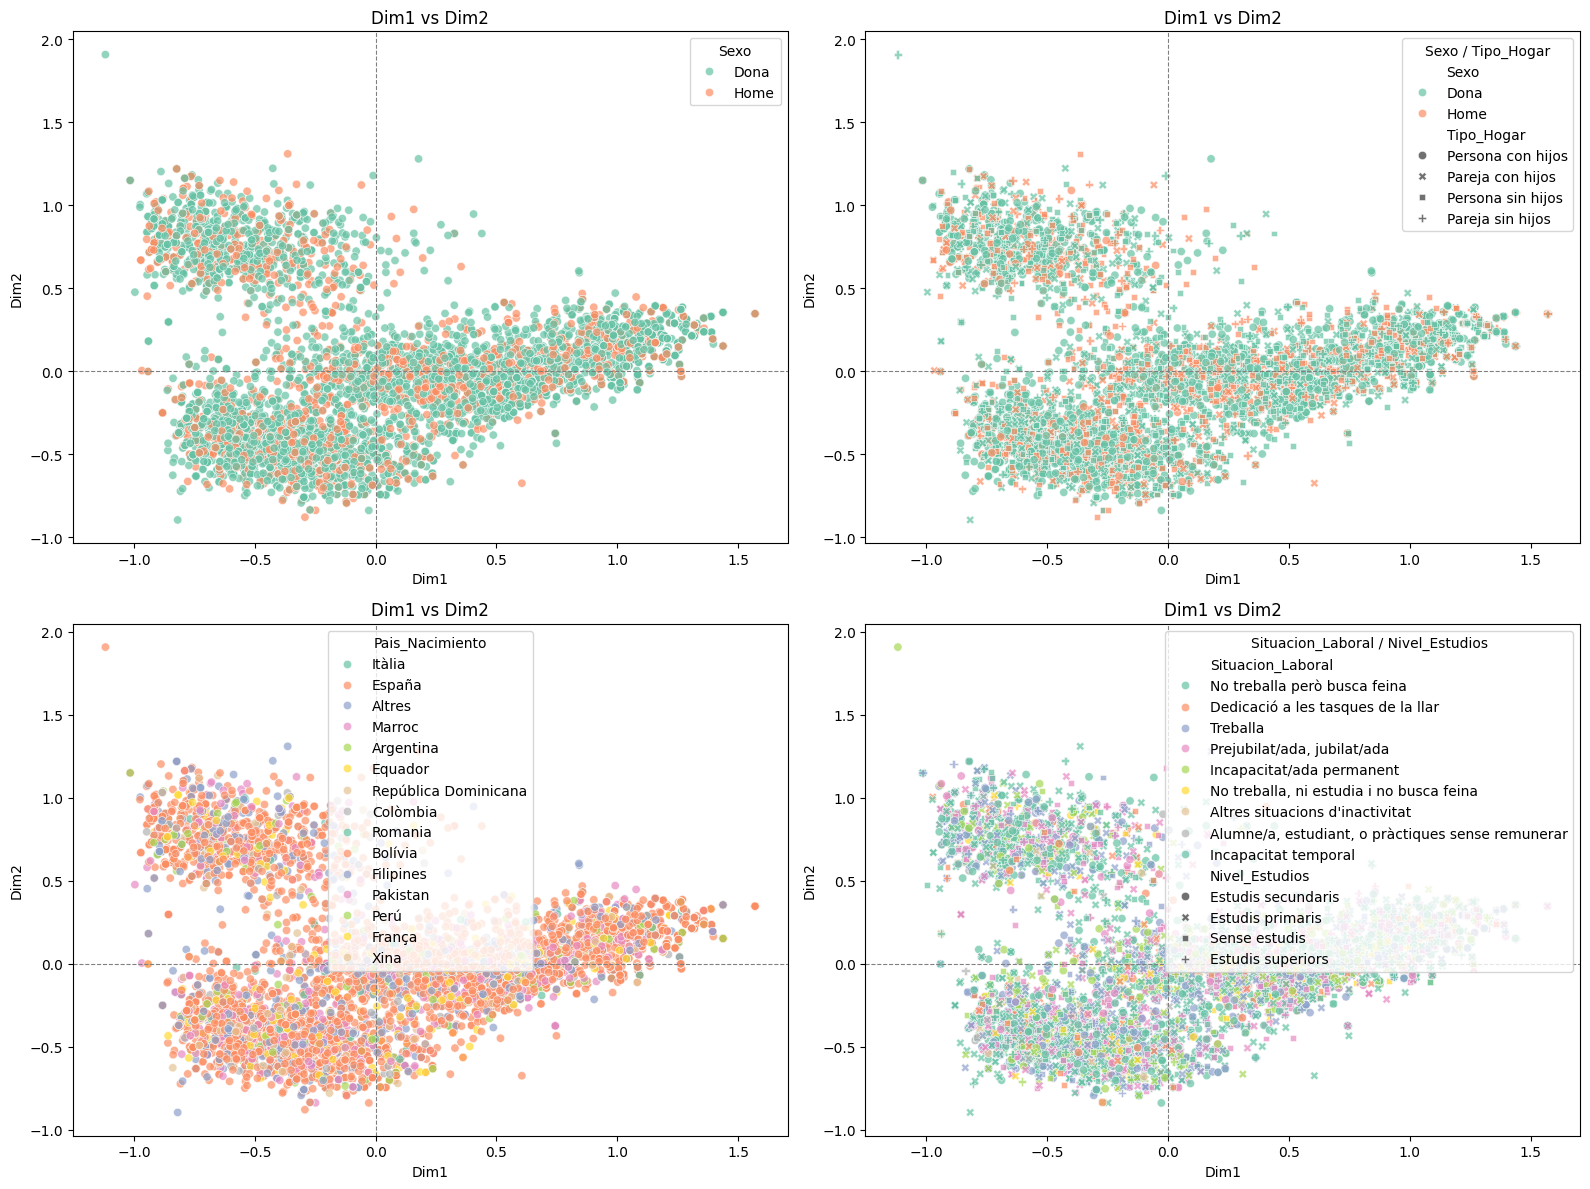

In [47]:
# Variables categóricas para colorear y diferenciar
hue_var = "Sexo"
style_var = "Tipo_Hogar"

# Crear configuraciones para múltiples gráficos
configs = [
    {"x_dim": "Dim1", "y_dim": "Dim2", "hue_var": hue_var, "title": "Dim1 vs Dim2"},
    {"x_dim": "Dim1", "y_dim": "Dim2", "hue_var": hue_var, "style_var": style_var, "title": "Dim1 vs Dim2"},
    {"x_dim": "Dim1", "y_dim": "Dim2", "hue_var": "Pais_Nacimiento", "title": "Dim1 vs Dim2"},
    {"x_dim": "Dim1", "y_dim": "Dim2", "hue_var": "Situacion_Laboral", "style_var": "Nivel_Estudios", "title": "Dim1 vs Dim2"},
]

# Generar los gráficos
plot_multiple_mca(df_mca_coords, configs)

### Interpretación de los resultados:

#### Varianza Explicada por Dimensión

En MCA, la varianza explicada por cada dimensión mide la inercia (variabilidad) capturada por los componentes principales. Los valores bajos de varianza explicada indican que:
- Los datos son muy dispersos.
- No hay una estructura latente fuerte que explique grandes porciones de variabilidad.

**Conclusión**: Este caso de ejemplo explica poquisima varianza. Hay que probar con menos variables y ver como cambia!!

En muchos casos, se espera que las primeras dimensiones expliquen al menos un 20-30% de la varianza acumulada. MCA tiende a distribuir la varianza entre muchas dimensiones si los datos son altamente heterogéneos (lo cual parece ser el caso aquí, dado el gran número de categorías y su variabilidad).

Para aumentar la varianza explicada podemos:
- Reducir el número de categorías por variable:
  - Si algunas variables tienen demasiadas categorías poco frecuentes, puedes agruparlas en menos categorías significativas.
- Eliminar variables menos relevantes:
  - Algunas variables pueden no contribuir significativamente a los patrones globales. Prueba eliminar variables y verifica si las primeras dimensiones explican más varianza.
    - Ejemplo: Si una variable tiene una distribución extremadamente sesgada (e.g., más del 90% de los valores en una sola categoría), podría no ser útil para MCA.
- Si tienes variables categóricas binarias o con muy pocas categorías, un CA (en lugar de MCA) puede ser más efectivo para explicar la varianza.

#### Aumentar el Número de Dimensiones

Aumentar el número de dimensiones aumenta la varianza acumulada. Sin embargo, la mayoría de estas dimensiones tendrán varianzas muy pequeñas y difíciles de interpretar. En este caso es probable que no tenga mucho sentido, porque solo las dos primeras dimensiones se grafican. Si estas dimensiones no explican patrones interesantes, agregar más no solucionará el problema.

#### Identificación de Patrones Interesantes

El principal uso de MCA para detectar patrones entre variables es analizar el espacio bidimensional graficado. Hay que buscar:
- Grupos de observaciones: Si los puntos se agrupan según una variable categórica (e.g., Sexo o Pais_Nacimiento), esto indica que la variable tiene una relación fuerte con los patrones generales.
- Distancia entre categorías: Las categorías cercanas en el gráfico son similares en términos de sus perfiles de respuesta.

En caso de no encontrar patrones interesantes, se puede recurrir a:
- Explorar dimensiones adicionales
- Usar las coordenadas de MCA como entrada para otros métodos, como:
  - Clustering (e.g., K-means): Identificar grupos latentes en las coordenadas.
  - Regresión o clasificación: Investigar si las dimensiones están relacionadas con alguna variable de interés.

#### Nota sobre la interpretación de la inclusión/exclusión de la variable objetivo

- Si el gráfico SIN la variable objetivo ya muestra agrupaciones por color (hue) significa que otras variables explican bien la variable objetivo.
- Si la estructura cambia significativamente cuando la incluyes, significa que la variable objetivo tiene una fuerte influencia en la formación de los componentes.
- Si no hay grupos claros en ninguna de las dos visualizaciones, entonces la variable objetivo no está bien representada en las dimensiones principales del MCA, y quizás necesites más dimensiones o revisar cómo están estructurados los datos.

### Explicación: "PCA como aproximación a MCA"

El Análisis de Correspondencia Múltiple (MCA) es una técnica específica diseñada para analizar relaciones entre variables categóricas, extendiendo el Análisis de Correspondencia Simple (CA) para múltiples dimensiones. El PCA (Análisis de Componentes Principales), por otro lado, se usa comúnmente para datos numéricos, pero puede servir como una aproximación al MCA cuando las variables categóricas se codifican como dummies (matriz de variables binarias).

En este caso, se podría intentar utilizar también PCA porque:
- Es compatible con datos categóricos codificados y numéricos combinados.
- Facilita la interpretación al reducir la dimensionalidad y revelar relaciones latentes entre las categorías.

**Atención!** He encontrado literatura al respecto en la que no dicen lo mismo. Para que PCA se convierta en FAMD (Factorial Analysis of Mixed Data) hay que realizar alguna transformación más a las variables categóricas codificadas...

https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210/

***
***
## 2.5 Regresión logística

La Regresión Logística modela la relación entre una o más variables independientes y una variable dependiente binaria o categórica, estimando probabilidades de pertenecer a cada clase.

#### Requisitos en los datos:
- Variable dependiente categórica: Debe ser binaria (0/1) o multinomial.
- Linealidad en las log-odds: Se asume que las variables independientes están linealmente relacionadas con el logaritmo de las odds.
- Independencia de las observaciones: Los datos deben ser independientes entre sí.

#### Buenas prácticas:
- Transformar variables categóricas:
    - Usar codificación (e.g., OneHot) para variables no numéricas.
- Evaluar multicolinealidad:
    - Detectar y eliminar variables redundantes con alta correlación.
- Balancear las clases:
    - Si las clases están desequilibradas, aplicar técnicas como sobremuestreo o ponderación.

#### Interpretación de los resultados:
- Coeficientes:
    - Indican el cambio en las log-odds por unidad de cambio en la variable independiente.
- Odds ratio:
    - Exponentiar los coeficientes para interpretar el efecto relativo.
- Métricas de evaluación:
    - Precision, recall, F1-score y curva ROC son fundamentales para evaluar el modelo.

***
***
## 2.6 Clustering

El Clustering agrupa observaciones similares en clústeres, basándose en medidas de similitud o distancia. No requiere una variable dependiente y es útil para descubrir patrones ocultos.

#### Requisitos en los datos:

- Variables numéricas o transformadas: Deben estar escaladas para evitar que una domine sobre las demás.
- Ausencia de ruido extremo: Los datos ruidosos pueden sesgar los clústeres.
- Adecuada dispersión: Los datos deben tener suficiente variabilidad para formar clústeres significativos.

#### Buenas prácticas:
- Escalar los datos:
    - Usar técnicas como StandardScaler para normalizar las variables.
- Elegir el número óptimo de clústeres:
    - Usar el método del codo o la métrica de silueta para determinar kk.
- Interpretar los clústeres:
    - Relacionar cada clúster con características específicas de las observaciones.

In [ ]:
### Interpretacion

Interpretación de los resultados:
- Centroides:
    - Representan el punto medio de cada clúster.
- Pertenencia a clústeres:
    - Observaciones cercanas al mismo clúster son similares entre sí.
- Visualización:
    - Usar PCA o t-SNE para proyectar los datos y observar los clústeres en 2D.

***
### 6.A Representación con PCA

***
### 6.B Representación con t-SNE

**t-SNE** (t-Distributed Stochastic Neighbor Embedding) es una técnica de reducción de dimensionalidad y visualización que:

- Preserva relaciones locales: Busca mantener la proximidad de puntos similares en el espacio original en un espacio de menor dimensión (típicamente 2D o 3D).
- No lineal: A diferencia de PCA o MCA, no se basa en una transformación lineal, sino en distribuciones de probabilidad.
- Visualización: Es ideal para descubrir estructuras ocultas o agrupamientos en los datos.

#### Aplicación a nuestros datos

Dado que estás explorando relaciones y agrupamientos entre categorías y patrones en datos multidimensionales, t-SNE puede ser útil porque:
- Relaciones locales: Es posible que existan agrupamientos que técnicas lineales como PCA o MCA no capturen bien.
- Variables categóricas: t-SNE puede trabajar con datos categóricos codificados como dummies, como en tu caso.
- Visualización complementaria: No reemplaza PCA o MCA, pero puede ofrecer una perspectiva adicional.

Consideraciones:
- No interpretable: A diferencia de PCA o MCA, no genera componentes fáciles de interpretar en términos de contribuciones de variables.
- Costoso computacionalmente: Escala mal con muchos datos; si tienes un dataset grande, puede ser necesario limitarlo.
- Hipótesis exploratoria: t-SNE es útil para explorar patrones, no para confirmarlos.

/home/narki/miniconda3/envs/doctorado/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


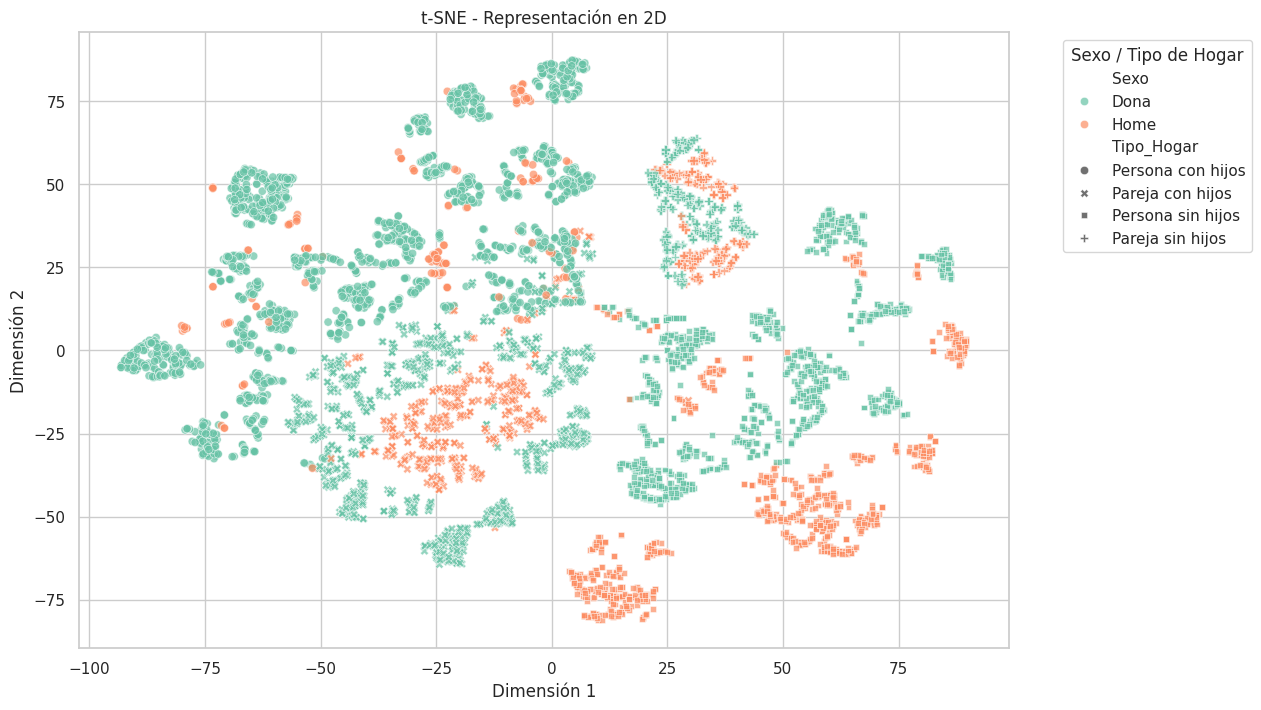

In [ ]:
from sklearn.manifold import TSNE

# Seleccionar y preprocesar los datos
variables_categoricas = ['Sexo', 'Nivel_Estudios', 'Tipo_Hogar',
                         'Visita_CSS_Econom', 'Visita_CSS_Familia', 'Visita_CSS_Depend']
variables_numericas = ['Edad', 'Renda_Total_Llar', 'N_Hijos_Llar']

# Filtrar el DataFrame y eliminar filas con valores nulos
df_tsne = df[variables_categoricas + variables_numericas].dropna()

# Codificar variables categóricas
encoder_tsne = OneHotEncoder(drop='first')
categorical_encoded_tsne = encoder_tsne.fit_transform(df_tsne[variables_categoricas]).toarray()

# Escalar variables numéricas
scaler_tsne = StandardScaler()
numerical_scaled_tsne = scaler_tsne.fit_transform(df_tsne[variables_numericas])

# Combinar datos categóricos codificados y numéricos escalados
data_combined_tsne = np.hstack([categorical_encoded_tsne, numerical_scaled_tsne])

# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, n_iter=1000)
tsne_result = tsne.fit_transform(data_combined_tsne)

# Crear un DataFrame con los resultados de t-SNE
tsne_coords_df = pd.DataFrame(tsne_result, columns=['Dim1', 'Dim2'])
tsne_coords_df = pd.concat([tsne_coords_df, df_tsne.reset_index(drop=True)], axis=1)

# Visualización de t-SNE
plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_coords_df, x='Dim1', y='Dim2', hue='Sexo', style='Tipo_Hogar', palette='Set2', alpha=0.7)
plt.title('t-SNE - Representación en 2D')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.legend(title='Sexo / Tipo de Hogar', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()